# Rampart flats

This notebook's a convenient local development tool integrated with python interpreter, interactive browser-based text editor and preliminary started local PostgreSQL DB. Feel free to use this document to easily explore databases filled with [rampart](https://github.com/xXxRisingTidexXx/rampart) miners & parsers. Happy coding!

In [112]:
from warnings import filterwarnings
from pandas import read_csv, DataFrame
from numpy import array
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler, MinMaxScaler, Normalizer
from seaborn import distplot, countplot
from matplotlib.pyplot import style, rcParams, subplots
from tabulate import tabulate
filterwarnings('ignore', message='numpy.dtype size changed')
filterwarnings('ignore', message='numpy.ufunc size changed')
%matplotlib inline
style.use('dark_background')
rcParams['figure.facecolor'] = '#111111'
rcParams['axes.facecolor'] = '#111111'
rcParams['axes.edgecolor'] = '#212121'
rcParams['axes.grid'] = True
rcParams['grid.color'] = '#212121'
rcParams['legend.frameon'] = False

<br />Lets load the whole *flats* table from the DB. Notice that the hostname equals the DB container name due to the common Docker network.

In [113]:
flats = read_csv('flats.csv', usecols=['origin_url', 'price', 'room_number', 'floor', 'total_floor', 'city', 'ssf', 'izf', 'gzf'])
flats = flats[flats['city'] == 'Вінниця']
flats.drop(columns=['city'], inplace=True)
flats['origin_url'] = flats['origin_url'].apply(lambda url: url[23:])

In [114]:
def render(dataframe, showindex=False):
    print(tabulate(dataframe, headers='keys', tablefmt='psql', numalign='right', showindex=showindex))

In [115]:
render(flats[['origin_url', 'price', 'ssf', 'izf', 'gzf']].head())

+-------------------------------------------------------------------------------------------------+---------+-------+---------+----------+
| origin_url                                                                                      |   price |   ssf |     izf |      gzf |
|-------------------------------------------------------------------------------------------------+---------+-------+---------+----------|
| realty-perevireno-prodaja-kvartira-vinnitsa-podole-pirogova-ulitsa-17433443.html                |   46500 |     0 | 1.18317 |  0.91496 |
| realty-perevireno-prodaja-kvartira-vinnitsa-staryiy-gorod-danila-nechaya-ulitsa-17258632.html   |   40000 |     0 | 6.67473 |  0.18782 |
| realty-perevireno-prodaja-kvartira-vinnitsa-lva-tolstogo-ulitsa-17615901.html                   |   72000 |     0 | 1.85951 | 0.908191 |
| realty-perevireno-prodaja-kvartira-vinnitsa-podole-professora-shulgi-ulitsa-17607586.html       |  115000 |     0 | 1.36184 |  2.44764 |
| realty-perevireno-prodaja

In [116]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611 entries, 6 to 3302
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   origin_url   611 non-null    object 
 1   price        611 non-null    int64  
 2   room_number  611 non-null    int64  
 3   floor        611 non-null    int64  
 4   total_floor  611 non-null    int64  
 5   ssf          611 non-null    float64
 6   izf          611 non-null    float64
 7   gzf          611 non-null    float64
dtypes: float64(3), int64(4), object(1)
memory usage: 43.0+ KB


In [117]:
render(flats.describe(), showindex=True)

+-------+---------+---------------+---------+---------------+-------+---------+----------+
|       |   price |   room_number |   floor |   total_floor |   ssf |     izf |      gzf |
|-------+---------+---------------+---------+---------------+-------+---------+----------|
| count |     611 |           611 |     611 |           611 |   611 |     611 |      611 |
| mean  | 48502.2 |       2.03273 | 4.95745 |       8.27332 |     0 | 4.96248 | 0.692109 |
| std   | 26402.9 |      0.879032 | 2.97004 |       3.04053 |     0 | 7.36661 | 0.994569 |
| min   |   15952 |             1 |       1 |             2 |     0 |       0 |        0 |
| 25%   |   32500 |             1 |       3 |             5 |     0 | 1.06439 | 0.186682 |
| 50%   |   43000 |             2 |       4 |             9 |     0 | 1.53009 | 0.434852 |
| 75%   |   56000 |             3 |       7 |            11 |     0 | 6.74108 |  0.91179 |
| max   |  275000 |             4 |      14 |            17 |     0 | 62.0364 |  15.6022 |

<br />Now it's the very time to explore the numerical data.

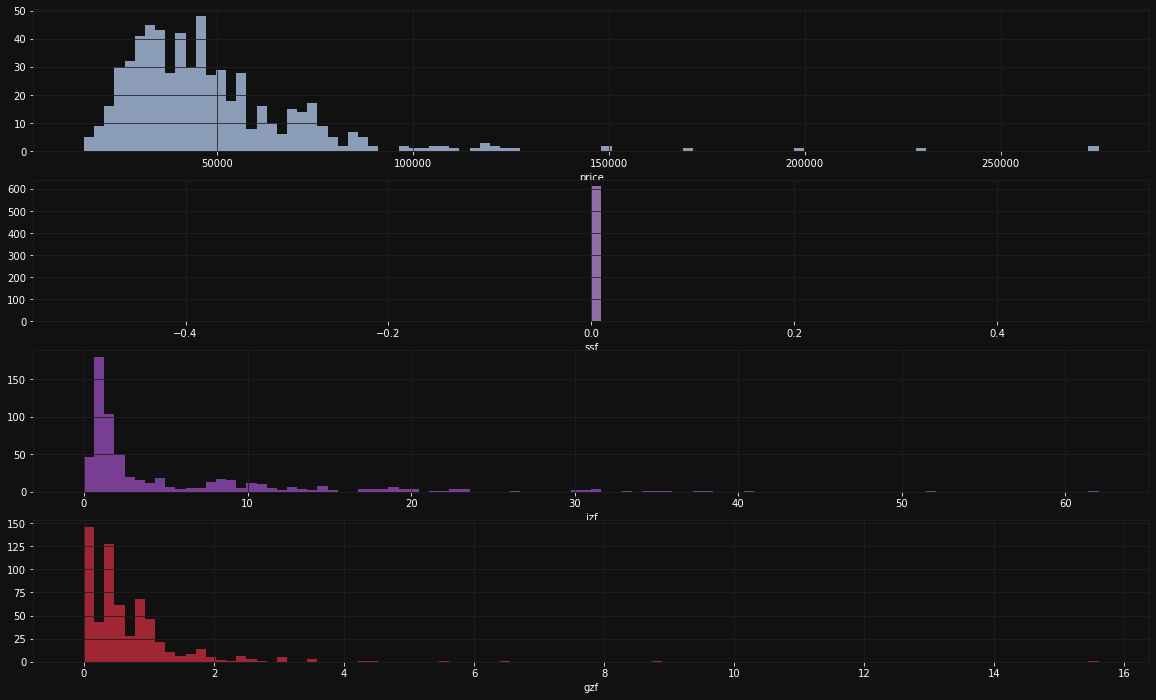

In [118]:
figure, axes = subplots(4, figsize=(20, 12))
distplot(flats['price'], ax=axes[0], color='#c0d8ff', kde=False, bins=100, hist_kws={'alpha': 0.7})
distplot(flats['ssf'], ax=axes[1], color='#ca95e5', kde=False, bins=100, hist_kws={'alpha': 0.7})
distplot(flats['izf'], ax=axes[2], color='#a352cc', kde=False, bins=100, hist_kws={'alpha': 0.7})
distplot(flats['gzf'], ax=axes[3], color='#e02f44', kde=False, bins=100, hist_kws={'alpha': 0.7})
pass

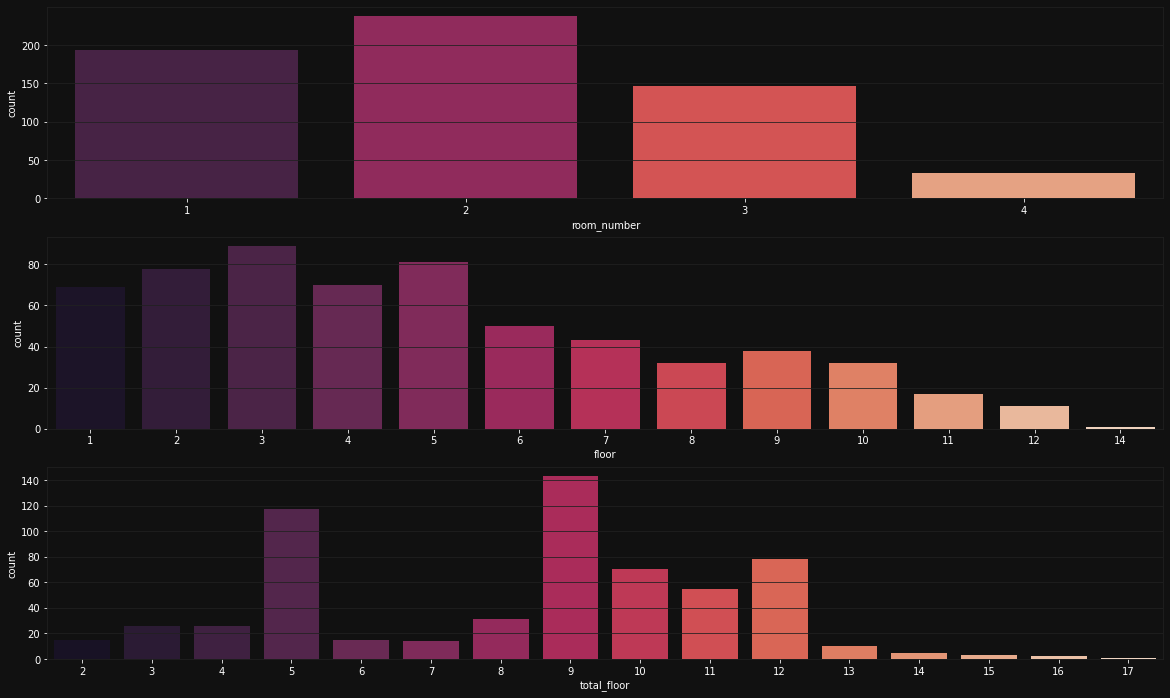

In [119]:
figure, axes = subplots(3, figsize=(20, 12))
countplot(flats['room_number'], palette='rocket', ax=axes[0])
countplot(flats['floor'], palette='rocket', ax=axes[1])
countplot(flats['total_floor'], palette='rocket', ax=axes[2])
pass

<br /> And now let's calculate distances by different metrics.

In [120]:
candidates = flats[['price', 'ssf', 'izf', 'gzf']]
scaler = MinMaxScaler()
scaler.fit(candidates)
candidates = scaler.transform(candidates)
preferences = scaler.transform(array([[60000, flats['ssf'].max(), 0, flats['gzf'].max()]]))
weights = array([1, 0.2, 0.2, 0.2])
for metric in ['cosine', 'canberra']:
    results = flats.copy()
    results['distance'] = cdist(candidates, preferences, metric, w=weights)
    render(results[['origin_url', 'price', 'ssf', 'izf', 'gzf', 'distance']].sort_values('distance').head(20))

+----------------------------------------------------------------------------------------------------------------------+---------+-------+----------+----------+------------+
| origin_url                                                                                                           |   price |   ssf |      izf |      gzf |   distance |
|----------------------------------------------------------------------------------------------------------------------+---------+-------+----------+----------+------------|
| realty-perevireno-prodaja-kvartira-vinnitsa-tsentr-magistratskaya-ulitsa-17476398.html                               |   67000 |     0 |  3.03781 |  15.6022 | 0.00233763 |
| realty-perevireno-prodaja-kvartira-vinnitsa-tsentr-magistratskaya-pervomayskaya-ulitsa-17602400.html                 |   40000 |     0 |  2.94772 |   8.8682 | 0.00315545 |
| realty-perevireno-prodaja-kvartira-vinnitsa-agronomichnoe-michurina-ulitsa-17369242.html                             |   33400 |